# Tidal Analysis

In [34]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from pathlib import Path
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from branca.colormap import linear
from shapely.geometry import Polygon, MultiPolygon

In [35]:
BASE = Path("/Users/kyledorman/data/planet_coverage/points_30km/")
FIG_DIR = BASE.parent / "figs" / "simulated_tidal"
FIG_DIR.mkdir(exist_ok=True, parents=True)

In [30]:
def fill_small_holes(geom, area_thresh):
    """Return a polygon with interior rings (holes) smaller than
    `area_thresh` removed (i.e. filled)."""
    if geom.is_empty or geom.geom_type not in {"Polygon", "MultiPolygon"}:
        return geom  # nothing to do

    def _fill(poly: Polygon) -> Polygon:
        # Keep exterior ring, drop any interior ring (hole) whose area < threshold
        holes_to_keep = [ring for ring in poly.interiors
                         if Polygon(ring).area >= area_thresh]
        return Polygon(poly.exterior, holes_to_keep)

    if geom.geom_type == "Polygon":
        return _fill(geom)
    else:  # MultiPolygon
        return MultiPolygon([_fill(p) for p in geom.geoms])

def clean_and_simplify(gdf: gpd.GeoDataFrame,
                       hole_area_thresh: float,
                       simplify_tolerance: float) -> gpd.GeoDataFrame:
    """Fill small holes, then simplify geometries (topology-preserving)."""
    gdf = gdf.copy()
    holeless = gdf.geometry.apply(fill_small_holes, area_thresh=hole_area_thresh)
    simp_geom = holeless.simplify(simplify_tolerance, preserve_topology=True)
    gdf.geometry = simp_geom
    return gdf

def assign_intersection_id(gdf, other_gdf, left_key, right_key, inter_crs, sinu_crs):
    gdf = gdf.copy()
    gdf["poly_area"] = gdf.geometry.area
    orig_crs = gdf.crs
    gdf = gdf.to_crs(inter_crs)
    other_gdf = other_gdf.to_crs(inter_crs)
    
    # Assign right_key to gdf
    inter_df = gdf[[left_key, "geometry"]].overlay(other_gdf[[right_key, "geometry"]], how="intersection")
    inter_df = inter_df.set_index(left_key).join(gdf.set_index(left_key)[["poly_area"]], how="left")
    inter_df = inter_df.to_crs(sinu_crs)
    inter_df["overlap_pct"] = inter_df.geometry.area / inter_df.poly_area
    inter_df = inter_df.reset_index().sort_values(by=[left_key, "overlap_pct"], ascending=False)
    inter_df = inter_df.drop_duplicates(subset=left_key).set_index(left_key)

    
    gdf = gdf.set_index(left_key).join(inter_df[[right_key]], how='left')
    
    invalid = gdf[right_key].isna()
    gdf.loc[invalid, right_key] = -1
    gdf[right_key] = gdf[right_key].astype(int)
    gdf = gdf.to_crs(orig_crs)

    return gdf.reset_index()
    

In [31]:
display_crs = "EPSG:4326"
sinu_crs = gpd.read_file(BASE / "ocean_grids.gpkg").crs

ecoregions = gpd.read_file(BASE.parent / "shorelines" / "marine_ecoregions").to_crs(display_crs)
ecoregions["eco_id"] = ecoregions.index
orig_area = ecoregions.geometry.area
ecoregions = ecoregions.to_crs(sinu_crs)
ecoregions = clean_and_simplify(ecoregions, hole_area_thresh=1e10, simplify_tolerance=1e4)
ecoregions = ecoregions.to_crs(display_crs)
new_area = ecoregions.geometry.area
ecoregions = ecoregions[orig_area / new_area > 0.5]

cell_size_m = compute_step(2.5)
_, hex_grid = make_equal_area_hex_grid(cell_size_m, sinu_crs)
hex_grid = hex_grid.to_crs(display_crs)
hex_grid["hex_id"] = hex_grid.cell_id

query_df = gpd.read_file(BASE / "ocean_grids.gpkg")
query_df = assign_intersection_id(query_df, ecoregions, "cell_id", "eco_id", display_crs, sinu_crs)
query_df = assign_intersection_id(query_df, hex_grid, "cell_id", "hex_id", display_crs, sinu_crs)

# Set plot crs
query_df = query_df.to_crs(display_crs)

# Load tidal data
tide_df = pd.read_csv(BASE / "simulated_tidal_coverage.csv").set_index("cell_id")
heuristics_df = pd.read_csv(BASE / "simulated_tidal_coverage_heuristics.csv").set_index("cell_id")

# Mark null values as full year
for col in tide_df.columns:
    tide_df.loc[tide_df[col].isna(), col] = 365.0
    assert not tide_df[col].isna().any()

# Merge all dataframes
query_df = query_df.set_index("cell_id")
tide_heuristics_grid_df = tide_df.join(heuristics_df).join(query_df[["geometry", "eco_id", "hex_id"]], how='inner')
tide_heuristics_grid_df = gpd.GeoDataFrame(tide_heuristics_grid_df, geometry="geometry", crs=display_crs)
tide_heuristics_grid_df["plot_id"] = tide_heuristics_grid_df.index.astype(str)

In [32]:
tide_heuristics_grid_df.head(3)

planet_min_observed_height  planet_max_observed_height  \
cell_id                                                           
8760                      -1.051447                    0.670052   
8761                      -1.031341                    0.592210   
8762                      -0.995060                    0.533437   

         planet_observed_tide_range  planet_observed_spread  \
cell_id                                                       
8760                       1.721499                0.681956   
8761                       1.623551                0.684238   
8762                       1.528497                0.681273   

         planet_observed_low_tide_offset_rel  \
cell_id                                        
8760                                0.062929   
8761                                0.043000   
8762                                0.037350   

         planet_observed_high_tide_offset_rel  \
cell_id                                         
8760                                 0.255114   
8761                                 0.272762   
8762                                 0.281376   

         planet_observed_low_tide_offset  planet_observed_high_tide_offset  \
cell_id                                                                      
8760                            0.158856                          0.643999   
8761                            0.102029                          0.647206   
8762                            0.083799                          0.631292   

         planet_low_days_between_p50  planet_low_days_between_p95  ...  \
cell_id                                                            ...   
8760                             1.0                    14.000903  ...   
8761                             1.0                    13.002049  ...   
8762                             1.0                    12.999618  ...   

         height_edge_5  height_edge_6  height_edge_7  height_edge_8  \
cell_id                                                               
8760         -0.005886       0.143181       0.285477       0.450622   
8761         -0.004292       0.142445       0.279068       0.434736   
8762         -0.002314       0.133825       0.261553       0.408619   

         height_edge_9  height_edge_10  \
cell_id                                  
8760          0.660328        1.314053   
8761          0.631911        1.239417   
8762          0.594536        1.164730   

                                                  geometry  eco_id  hex_id  \
cell_id                                                                      
8760     POLYGON ((21.9613 -35.04327, 21.69931 -34.0397...       0    1348   
8761     POLYGON ((23.18137 -35.04327, 22.90482 -34.039...       0    1348   
8762     POLYGON ((24.40144 -35.04327, 24.11034 -34.039...       0    1349   

         plot_id  
cell_id           
8760        8760  
8761        8761  
8762        8762  

[3 rows x 74 columns]

In [33]:
heuristics_df.head(5)

tide_min  tide_max  tide_mean  tide_std  tide_median  tide_p95  \
cell_id                                                                   
8760    -1.210303  1.314052   0.000037  0.486256    -0.005886  0.790068   
8761    -1.133370  1.239416   0.000025  0.465730    -0.004292  0.753267   
8762    -1.078859  1.164729   0.000026  0.438433    -0.002314  0.708931   
8763    -1.013167  1.088741   0.000021  0.410555    -0.002113  0.665082   
8764    -1.000019  1.075298   0.000022  0.405768    -0.001633  0.655893   

         tide_range  tide_iqr  height_edge_0  height_edge_1  height_edge_2  \
cell_id                                                                      
8760       2.524355  0.729280      -1.210304      -0.652189      -0.448576   
8761       2.372786  0.705742      -1.133371      -0.626004      -0.433147   
8762       2.243588  0.662092      -1.078860      -0.590447      -0.408333   
8763       2.101908  0.618227      -1.013168      -0.554096      -0.381302   
8764       2.075318  0.613088      -1.000020      -0.547248      -0.377748   

         height_edge_3  height_edge_4  height_edge_5  height_edge_6  \
cell_id                                                               
8760         -0.287232      -0.153770      -0.005886       0.143181   
8761         -0.280404      -0.150778      -0.004292       0.142445   
8762         -0.263098      -0.139317      -0.002314       0.133825   
8763         -0.244976      -0.129173      -0.002113       0.123680   
8764         -0.243629      -0.128420      -0.001633       0.123722   

         height_edge_7  height_edge_8  height_edge_9  height_edge_10  
cell_id                                                               
8760          0.285477       0.450622       0.660328        1.314053  
8761          0.279068       0.434736       0.631911        1.239417  
8762          0.261553       0.408619       0.594536        1.164730  
8763          0.243251       0.382752       0.557245        1.088742  
8764          0.242271       0.378746       0.550394        1.075299

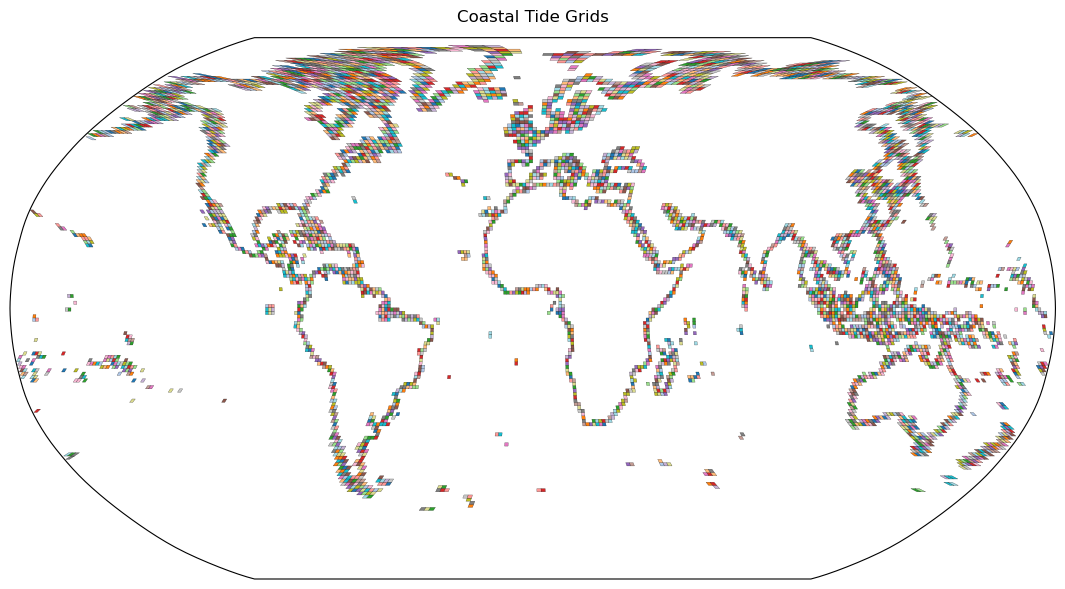

In [7]:
gdf = tide_heuristics_grid_df[["geometry"]].copy()

ids = list(range(len(gdf)))
shuffle(ids)
gdf["id"] = ids

n_ids  = gdf["id"].nunique()
base_cmap = cm.get_cmap("tab20", n_ids)  # up to 20 unique colours
cmap      = colors.ListedColormap(base_cmap(range(n_ids)))
norm      = colors.BoundaryNorm(range(n_ids + 1), n_ids)

# Pick any Cartopy projection
proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

fig = plt.figure(figsize=(12, 6))
ax  = plt.axes(projection=proj)
ax.set_global()

# Re-project your data on the fly with `transform`
gdf.plot(
    column="id",
    ax=ax,
    cmap=cmap,
    norm=norm,
    linewidth=0.15,
    edgecolor="black",
    transform=ccrs.PlateCarree(),   # <- incoming lon/lat coords
)

plt.title("Coastal Tide Grids", pad=12)
plt.tight_layout()
plt.savefig("/Users/kyledorman/Desktop/tidal_area.png")
plt.show()

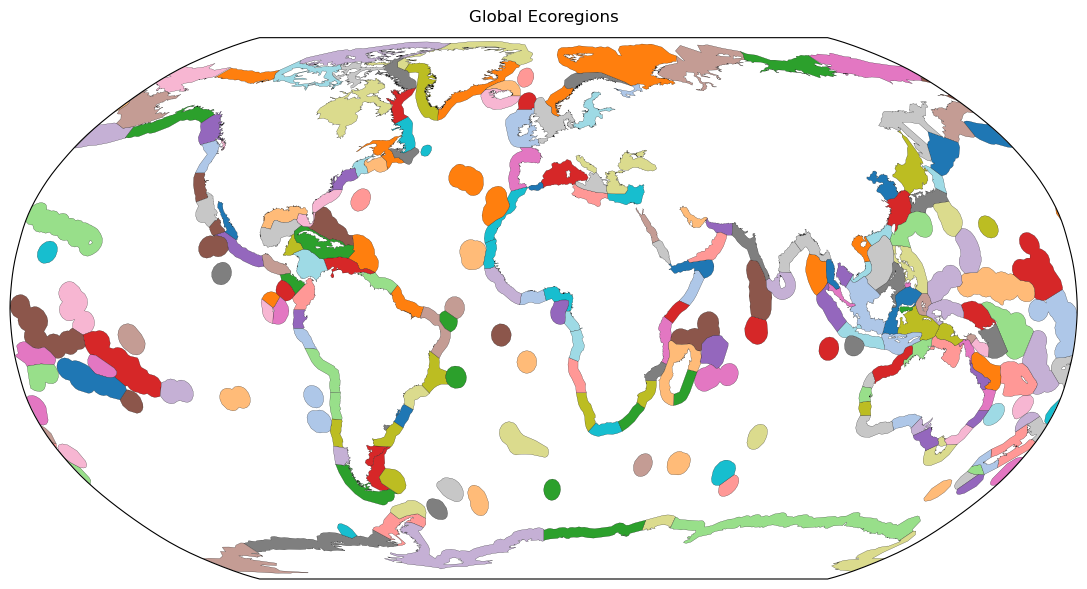

In [8]:
gdf = ecoregions.copy()

ids = list(range(len(gdf)))
shuffle(ids)
gdf["id"] = ids

n_ids  = gdf["id"].nunique()
base_cmap = cm.get_cmap("tab20", n_ids)  # up to 20 unique colours
cmap      = colors.ListedColormap(base_cmap(range(n_ids)))
norm      = colors.BoundaryNorm(range(n_ids + 1), n_ids)

# Pick any Cartopy projection
proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

fig = plt.figure(figsize=(12, 6))
ax  = plt.axes(projection=proj)
ax.set_global()

# Re-project your data on the fly with `transform`
gdf.plot(
    column="id",
    ax=ax,
    cmap=cmap,
    norm=norm,
    linewidth=0.15,
    edgecolor="black",
    transform=ccrs.PlateCarree(),   # <- incoming lon/lat coords
)

plt.title("Global Ecoregions", pad=12)
plt.tight_layout()
plt.savefig("/Users/kyledorman/Desktop/eco_regions.png")
plt.show()

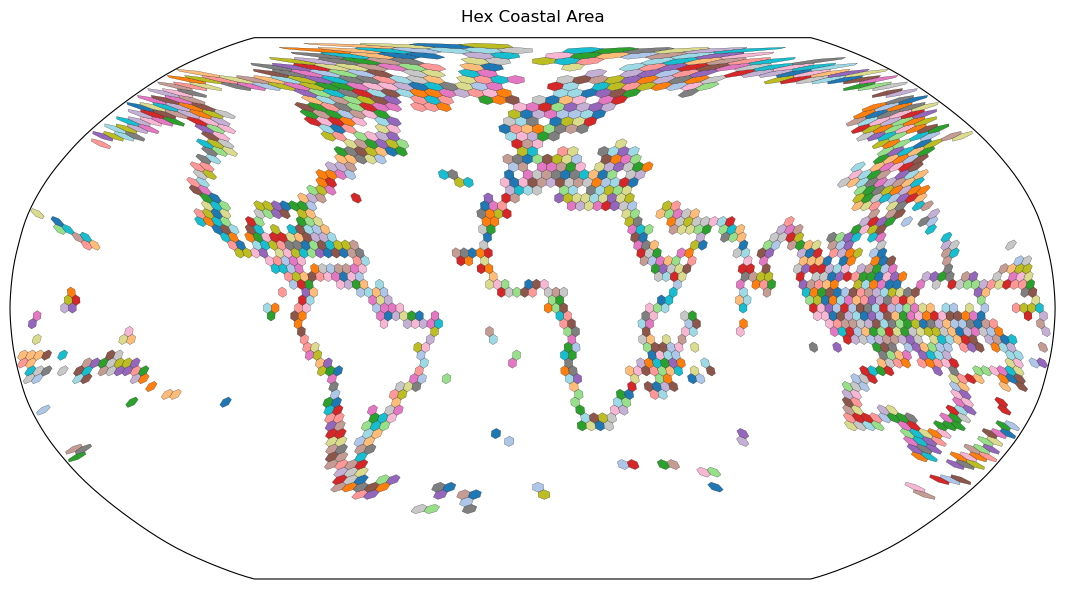

In [9]:
gdf = hex_grid[hex_grid.hex_id.isin(tide_heuristics_grid_df.hex_id.unique())]
ids = list(range(len(gdf)))
shuffle(ids)
gdf["id"] = ids

n_ids  = gdf.id.nunique()
base_cmap = cm.get_cmap("tab20", n_ids)  # up to 20 unique colours
cmap      = colors.ListedColormap(base_cmap(range(n_ids)))
norm      = colors.BoundaryNorm(range(n_ids + 1), n_ids)

# Pick any Cartopy projection
proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

fig = plt.figure(figsize=(12, 6))
ax  = plt.axes(projection=proj)
ax.set_global()

# Re-project your data on the fly with `transform`
gdf.plot(
    column="id",
    ax=ax,
    cmap=cmap,
    norm=norm,
    linewidth=0.15,
    edgecolor="black",
    transform=ccrs.PlateCarree(),   # <- incoming lon/lat coords
)

plt.title("Hex Coastal Area", pad=12)
plt.tight_layout()
plt.savefig("/Users/kyledorman/Desktop/hex_coastal_area.png")
plt.show()

In [10]:
# import polars as pl
# from src.query_udms import DataFrameRow

# all_lazy = pl.scan_parquet(
#     str(BASE / "*/results/*/*/*/*/data.parquet"),
#     schema=DataFrameRow.polars_schema(),
# )
# valid_cell_ids = all_lazy.select(pl.col("cell_id").unique().sort()).collect().to_series().to_list()
# print(len(valid_cell_ids))
# gdf = gpd.read_file(BASE / "ocean_grids.gpkg") # tide_heuristics_grid_df.reset_index()[["geometry"]].copy()
# gdf = gdf.set_index("cell_id").loc[valid_cell_ids].reset_index()

# ids = list(range(len(gdf)))
# shuffle(ids)
# gdf["id"] = ids

# n_ids  = gdf.id.nunique()
# base_cmap = cm.get_cmap("tab20", n_ids)  # up to 20 unique colours
# cmap      = colors.ListedColormap(base_cmap(range(n_ids)))
# norm      = colors.BoundaryNorm(range(n_ids + 1), n_ids)

# # Pick any Cartopy projection
# proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

# fig = plt.figure(figsize=(12, 6))
# ax  = plt.axes(projection=proj)
# ax.set_global()

# # Re-project your data on the fly with `transform`
# gdf.plot(
#     column="id",
#     ax=ax,
#     cmap=cmap,
#     norm=norm,
#     linewidth=0.15,
#     edgecolor="black",
#     transform=ccrs.Sinusoidal(),   # <- incoming lon/lat coords
# )

# plt.title("Observed Ocean Grids", pad=12)
# plt.tight_layout()
# plt.savefig("/Users/kyledorman/Desktop/observed_ocean_grids.png")
# plt.show()

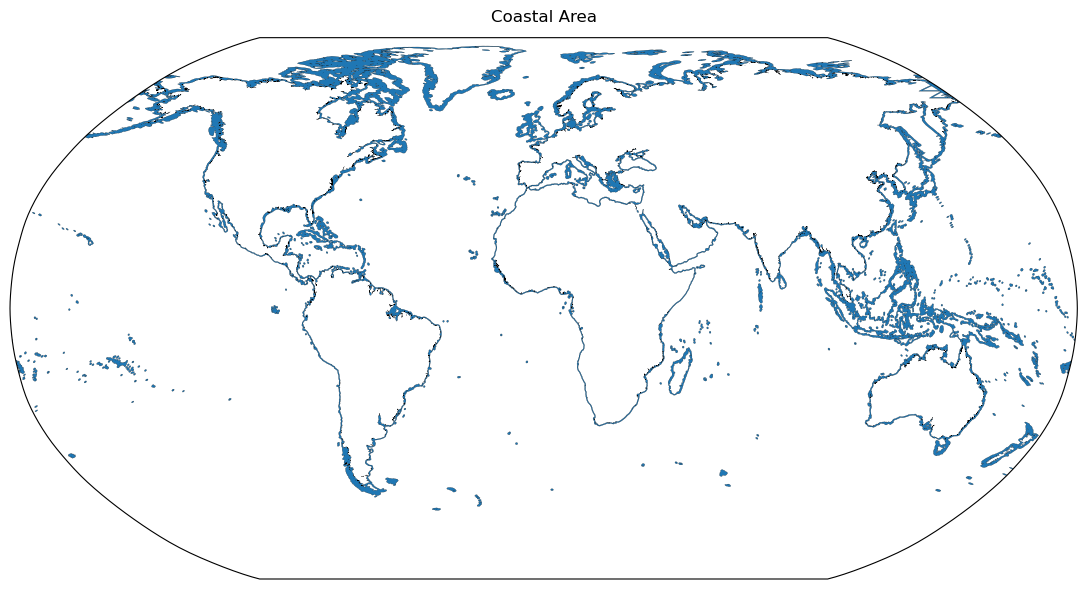

In [11]:
gdf = gpd.read_file(BASE / "coastal_strips.gpkg")
ids = list(range(len(gdf)))
shuffle(ids)
gdf["id"] = ids

n_ids  = gdf.id.nunique()
base_cmap = cm.get_cmap("tab20", n_ids)  # up to 20 unique colours
cmap      = colors.ListedColormap(base_cmap(range(n_ids)))
norm      = colors.BoundaryNorm(range(n_ids + 1), n_ids)

# Pick any Cartopy projection
proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

fig = plt.figure(figsize=(12, 6))
ax  = plt.axes(projection=proj)
ax.set_global()

# Re-project your data on the fly with `transform`
gdf.plot(
    column="id",
    ax=ax,
    cmap=cmap,
    norm=norm,
    linewidth=0.15,
    edgecolor="black",
    transform=ccrs.Sinusoidal(),   # <- incoming lon/lat coords
)

plt.title("Coastal Area", pad=12)
plt.tight_layout()
plt.savefig("/Users/kyledorman/Desktop/coastal_area.png")
plt.show()

In [12]:
def plot_gdf_column(
    gdf: gpd.GeoDataFrame,
    column: str,
    *,
    projection: ccrs.CRS = ccrs.Robinson(),
    cmap: str = "plasma",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    scale: str = "linear",               # "linear"  or  "log"
    figsize: Tuple[int, int] = (12, 6),
    edgecolor: str = "black",
    linewidth: float = 0.15,
    show_coastlines: bool = True,
    show_grid: bool = False,
    title: Optional[str] = None,
    save_path: str | None = None,
) -> None:
    """
    Plot a numeric column from a GeoDataFrame on a Cartopy map.

    Parameters
    ----------
    scale : {"linear", "log"}
        Colour normalisation.  "log" uses a base-10 LogNorm and
        *requires positive values*.
    All other parameters unchanged from previous version.
    """
    # ------------------------------------------------------------------
    # Basic checks
    # ------------------------------------------------------------------
    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        raise ValueError("GeoDataFrame must be in EPSG:4326 (lon/lat degrees)")
    if column not in gdf.columns:
        raise KeyError(f"{column!r} not found in GeoDataFrame")

    data = gdf[column].astype(float)

    # ------------------------------------------------------------------
    # Determine colour range & normalisation
    # ------------------------------------------------------------------
    if vmin is None:
        vmin = data[data > 0].min() if scale == "log" else data.min()
    if vmax is None:
        vmax = data.max()

    if scale == "log":
        if (data <= 0).any():
            raise ValueError("Log scale selected but column contains non-positive values.")
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
        # Tick locator/formatter for clean, linear-value ticks
        formatter = ticker.FuncFormatter(lambda y, _: f"{y:g}")
        locator = ticker.LogLocator(base=10, numticks=10)
    else:  # linear
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        formatter = ticker.ScalarFormatter()
        locator = ticker.MaxNLocator(nbins=6)

    cmap = cm.get_cmap(cmap)

    # ------------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)
    ax.set_global()

    gdf.plot(
        column=column,
        cmap=cmap,
        norm=norm,
        ax=ax,
        transform=ccrs.PlateCarree(),
        edgecolor=edgecolor,
        linewidth=linewidth,
    )

    if show_coastlines:
        ax.coastlines(resolution="110m", linewidth=0.3)
    if show_grid:
        ax.gridlines(draw_labels=False, linewidth=0.2)

    # Colour bar with human-readable ticks
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical",
                        shrink=0.65, pad=0.02, format=formatter)
    cbar.locator = locator
    cbar.update_ticks()
    cbar.set_label(column)

    if title:
        ax.set_title(title, pad=12)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [13]:
[p for p in tide_heuristics_grid_df.columns if p.startswith("planet")]

['planet_min_observed_height',
 'planet_max_observed_height',
 'planet_observed_tide_range',
 'planet_observed_spread',
 'planet_observed_low_tide_offset_rel',
 'planet_observed_high_tide_offset_rel',
 'planet_observed_low_tide_offset',
 'planet_observed_high_tide_offset',
 'planet_low_days_between_p50',
 'planet_low_days_between_p95',
 'planet_low_count',
 'planet_high_days_between_p50',
 'planet_high_days_between_p95',
 'planet_high_count',
 'planet_mid_days_between_p50',
 'planet_mid_days_between_p95',
 'planet_mid_count']

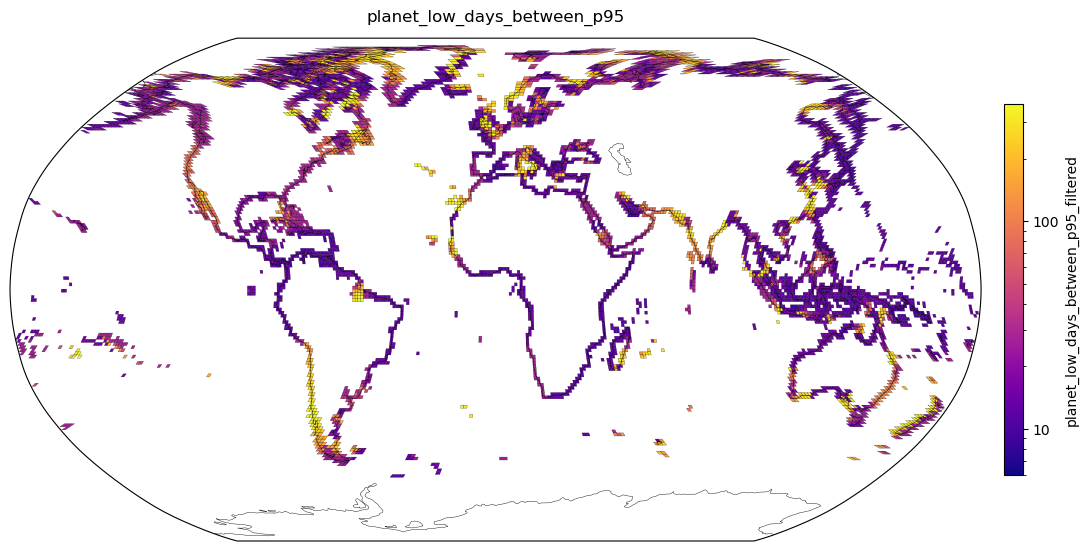

In [14]:
tide_heuristics_grid_df['planet_low_days_between_p95_filtered'] = tide_heuristics_grid_df['planet_low_days_between_p95']

tide_heuristics_grid_df.loc[
    tide_heuristics_grid_df.planet_low_count == 0,
    'planet_low_days_between_p95_filtered'
] = 15

plot_gdf_column(
    tide_heuristics_grid_df, 
    'planet_low_days_between_p95_filtered', 
    title='planet_low_days_between_p95', 
    scale='log',
    # save_path="/Users/kyledorman/Desktop/planet_low_days_between_p95.png",
)

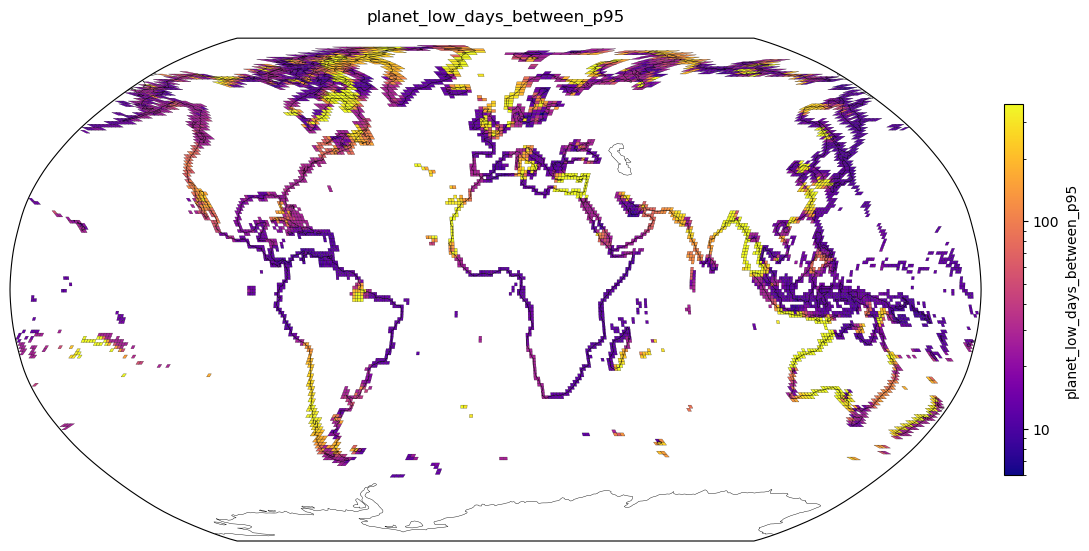

In [15]:
plot_gdf_column(
    tide_heuristics_grid_df, 
    'planet_low_days_between_p95', 
    title='planet_low_days_between_p95', 
    scale='log',
    save_path="/Users/kyledorman/Desktop/planet_low_days_between_p95.png",
)

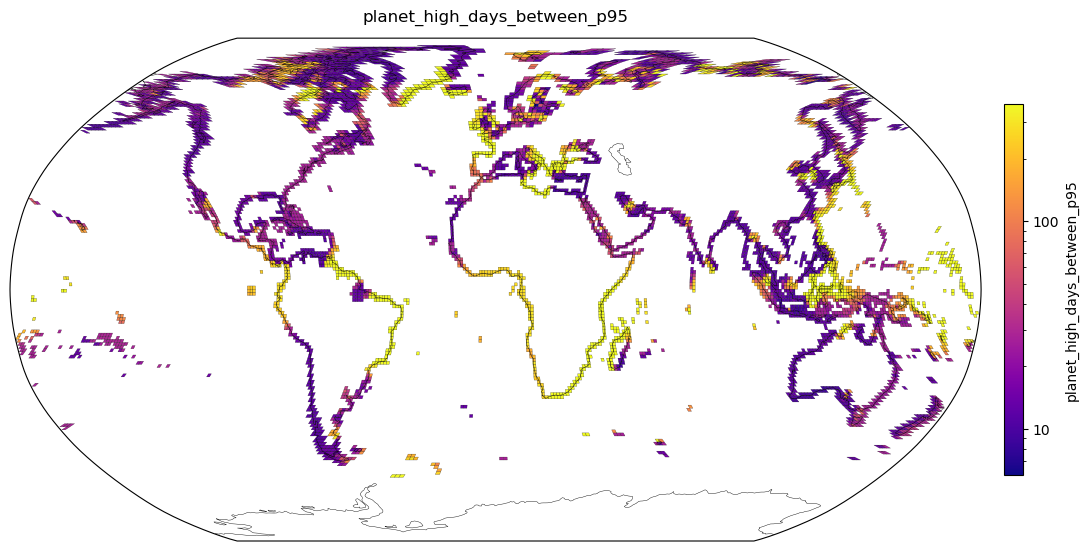

In [16]:
plot_gdf_column(tide_heuristics_grid_df, 'planet_high_days_between_p95', title='planet_high_days_between_p95', scale='log')

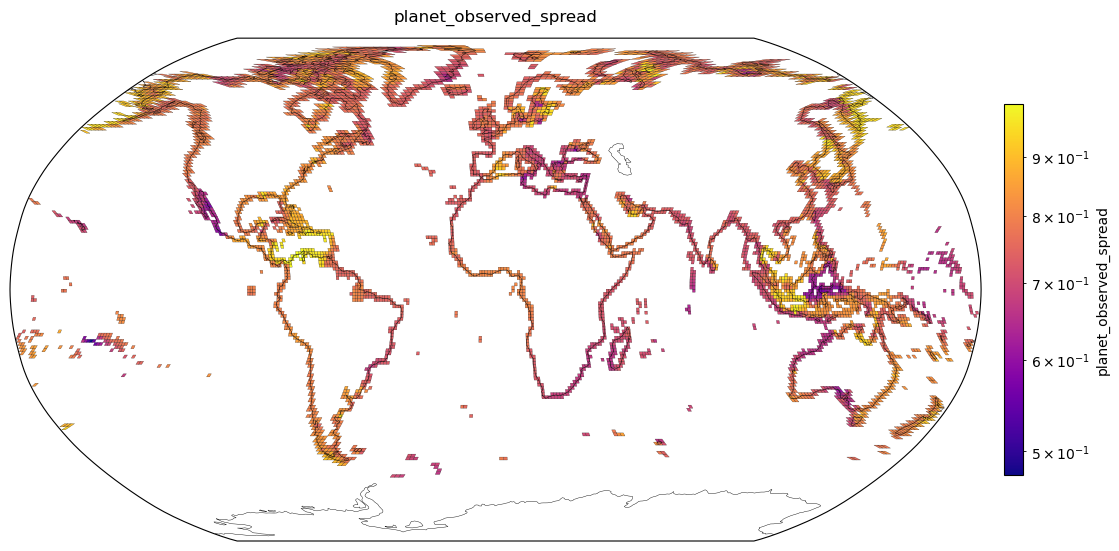

In [17]:
plot_gdf_column(tide_heuristics_grid_df, 'planet_observed_spread', title='planet_observed_spread', scale='log')

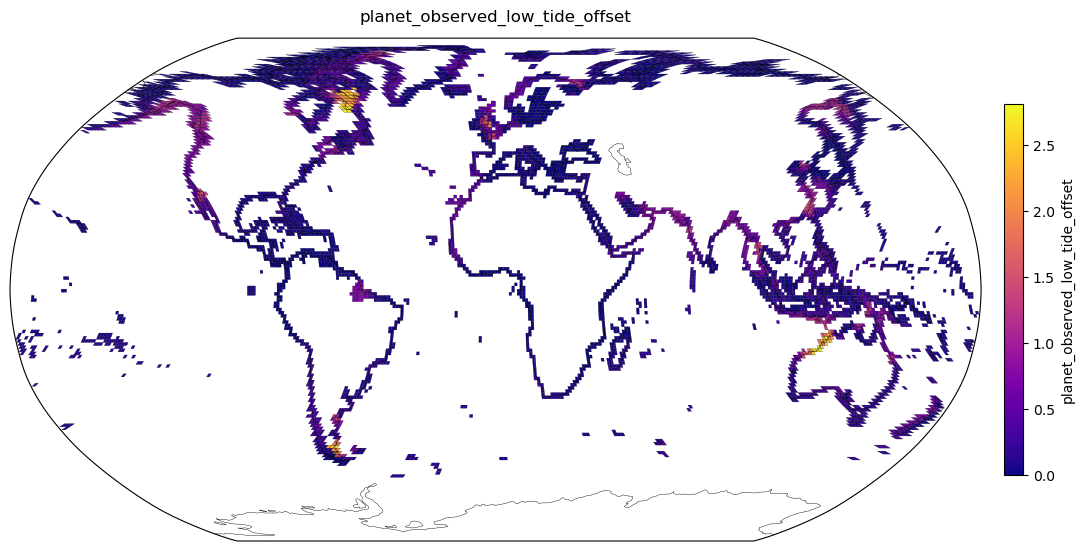

In [18]:
plot_gdf_column(tide_heuristics_grid_df, 'planet_observed_low_tide_offset', title='planet_observed_low_tide_offset')

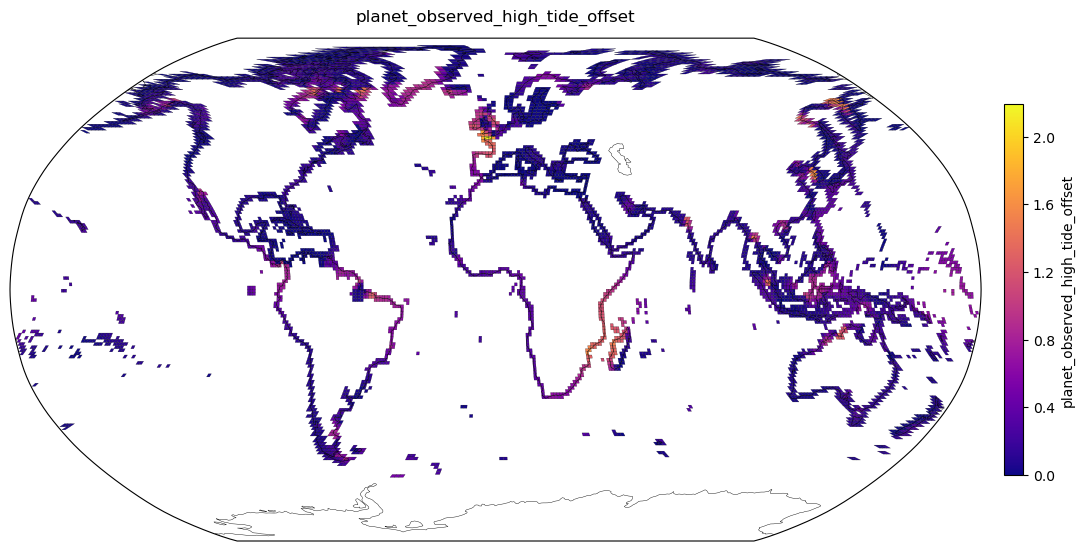

In [19]:
plot_gdf_column(tide_heuristics_grid_df, 'planet_observed_high_tide_offset', title='planet_observed_high_tide_offset')

In [20]:
tide_heuristics_grid_df['planet_observed_high_tide_offset'].min()

0.0

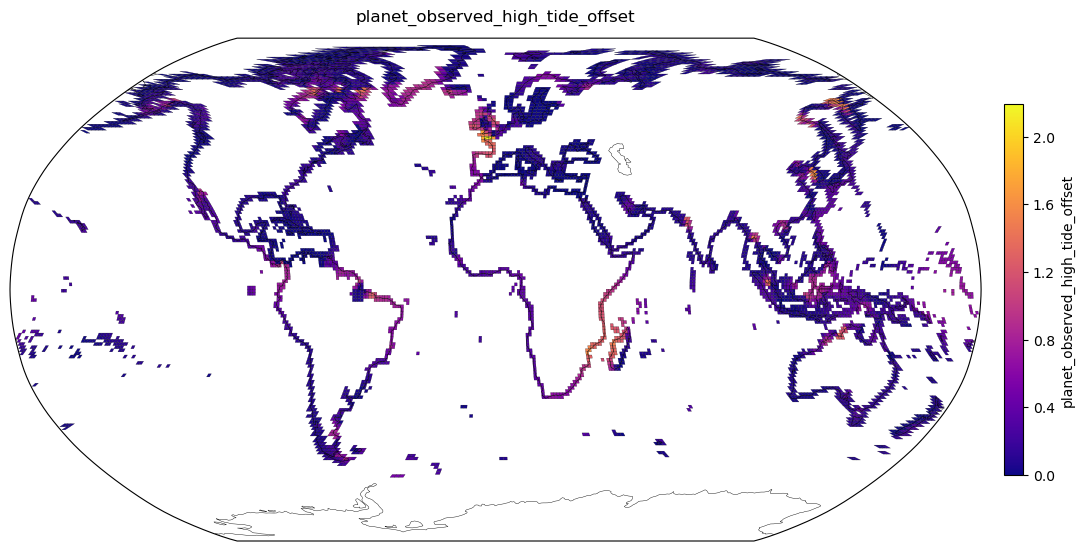

In [21]:
key = 'planet_observed_high_tide_offset'
plot_gdf_column(tide_heuristics_grid_df, key, title=key)

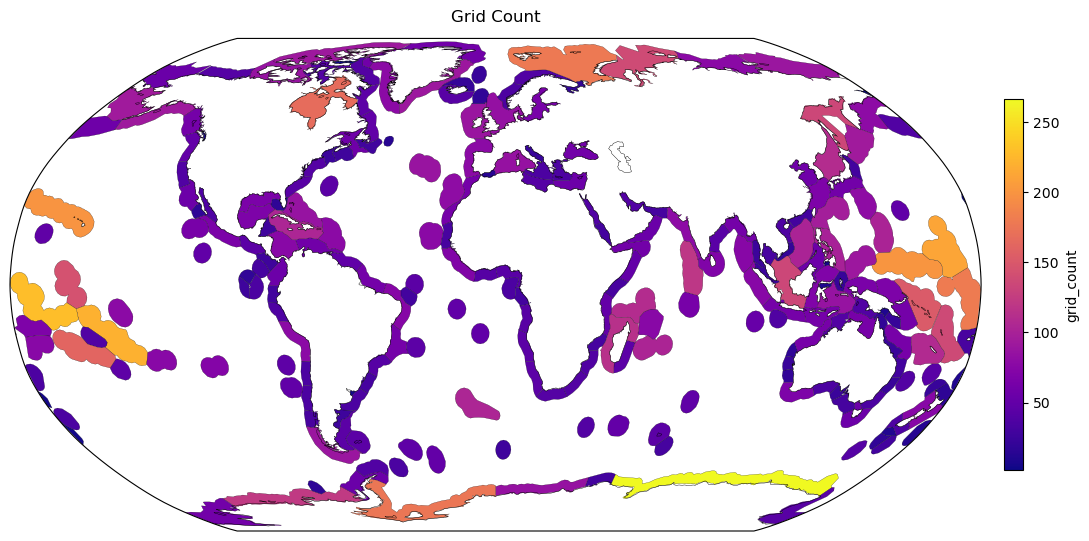

In [22]:
df = pd.DataFrame(query_df.groupby("eco_id").eco_id.count()).rename(columns={"eco_id": "grid_count"})
df = df[df.index >= 0]
df = df.join(ecoregions[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(gdf, "grid_count", title="Grid Count")


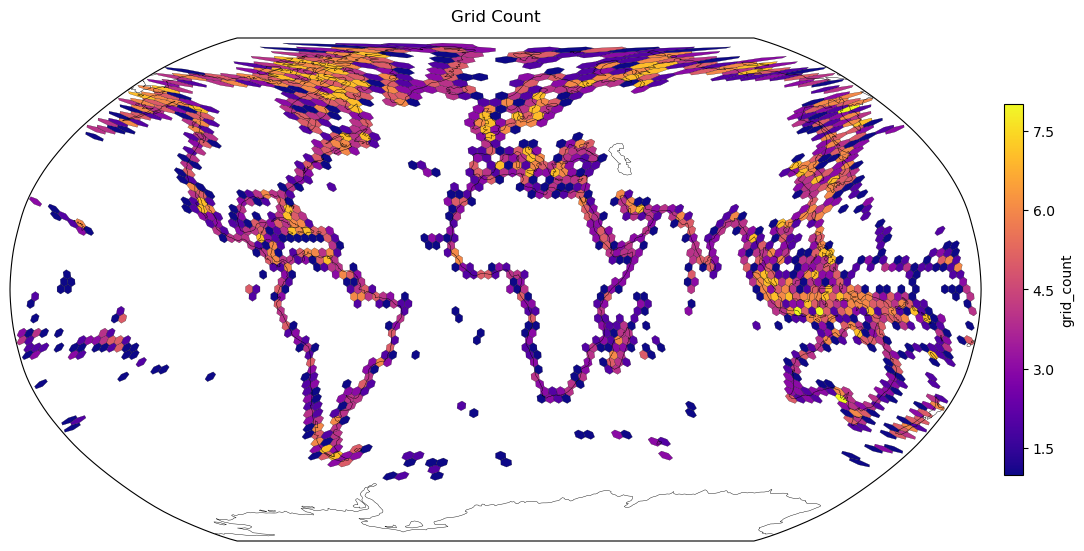

In [23]:
df = pd.DataFrame(tide_heuristics_grid_df.groupby("hex_id")["hex_id"].count()).rename(columns={"hex_id": "grid_count"})
df = df[df.index >= 0]
df = df.join(hex_grid[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(gdf, "grid_count", title="Grid Count")


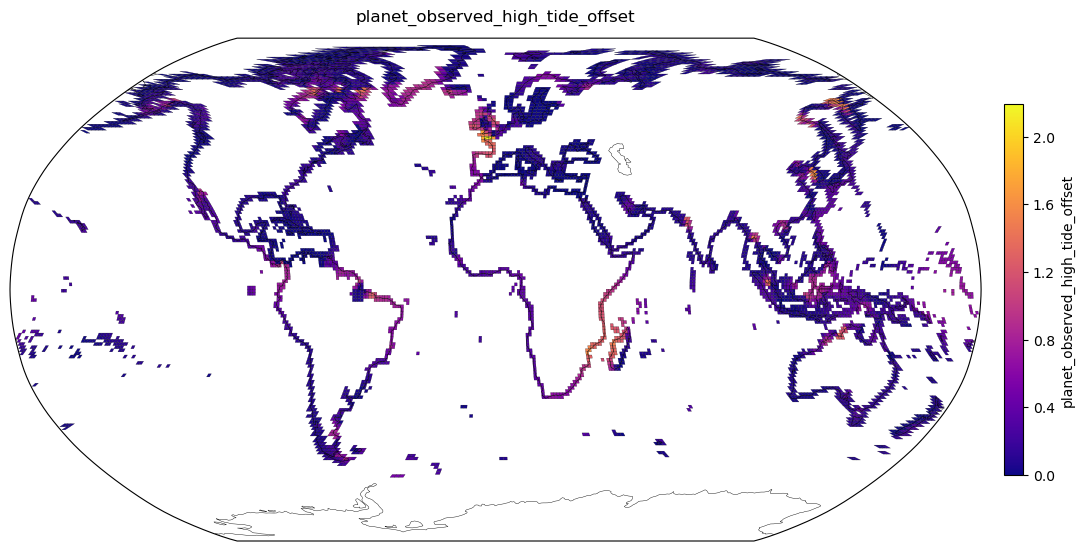

In [24]:
plot_gdf_column(
    tide_heuristics_grid_df, 
    'planet_observed_high_tide_offset', 
    title="planet_observed_high_tide_offset"
)

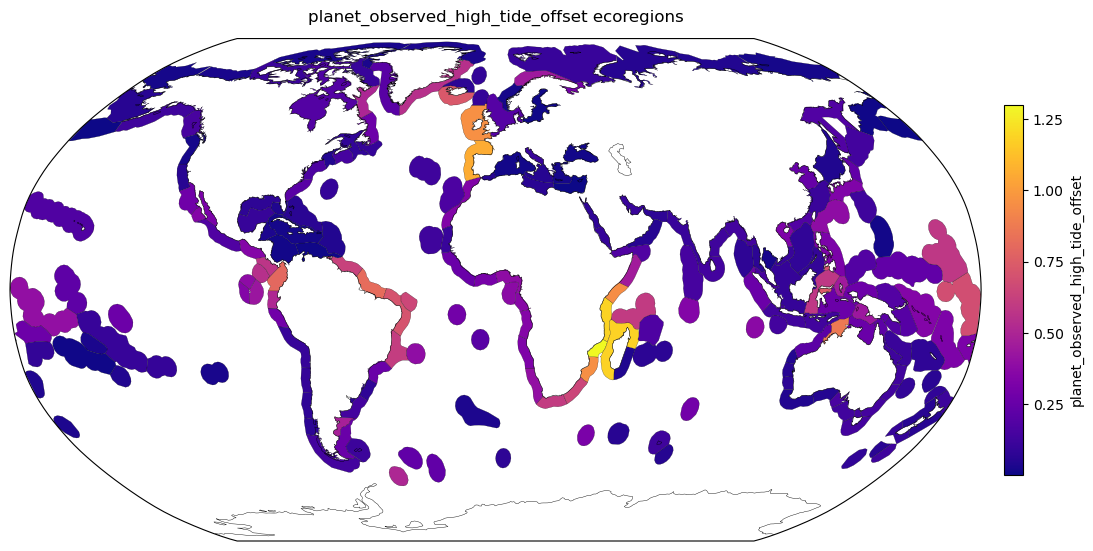

In [25]:
df = pd.DataFrame(tide_heuristics_grid_df.groupby("eco_id").planet_observed_high_tide_offset.median())
df = df[df.index >= 0]
df = df.join(ecoregions[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(
    gdf, 
    "planet_observed_high_tide_offset", 
    title="planet_observed_high_tide_offset ecoregions",
    # save_path="/Users/kyledorman/Desktop/tide_range_ecoregions.png"
)

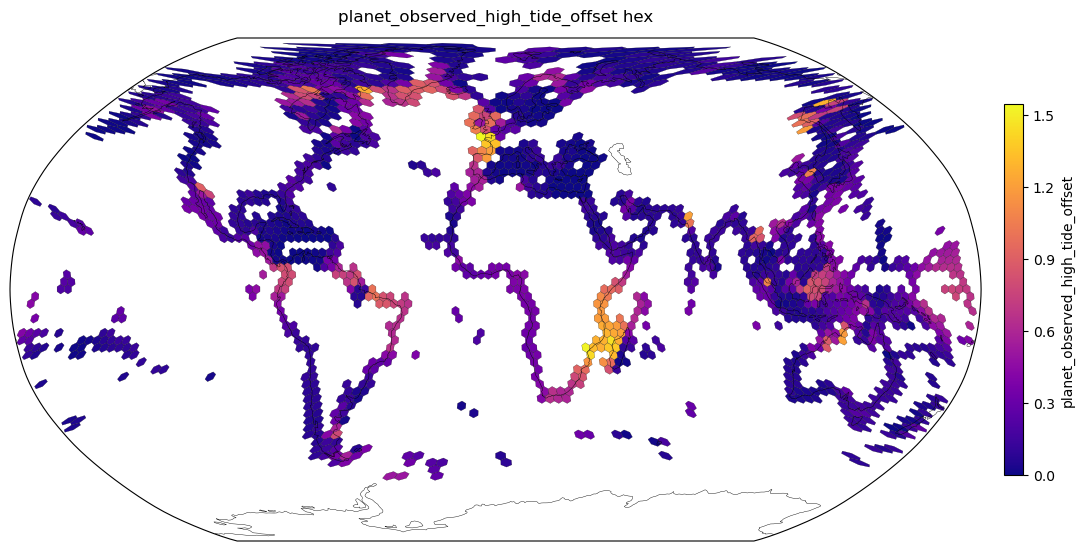

In [26]:
df = pd.DataFrame(tide_heuristics_grid_df.groupby("hex_id").planet_observed_high_tide_offset.median())
df = df[df.index >= 0]
df = df.join(hex_grid[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(
    gdf, 
    "planet_observed_high_tide_offset", 
    title="planet_observed_high_tide_offset hex",
    # save_path="/Users/kyledorman/Desktop/tide_range_hex.png"
)

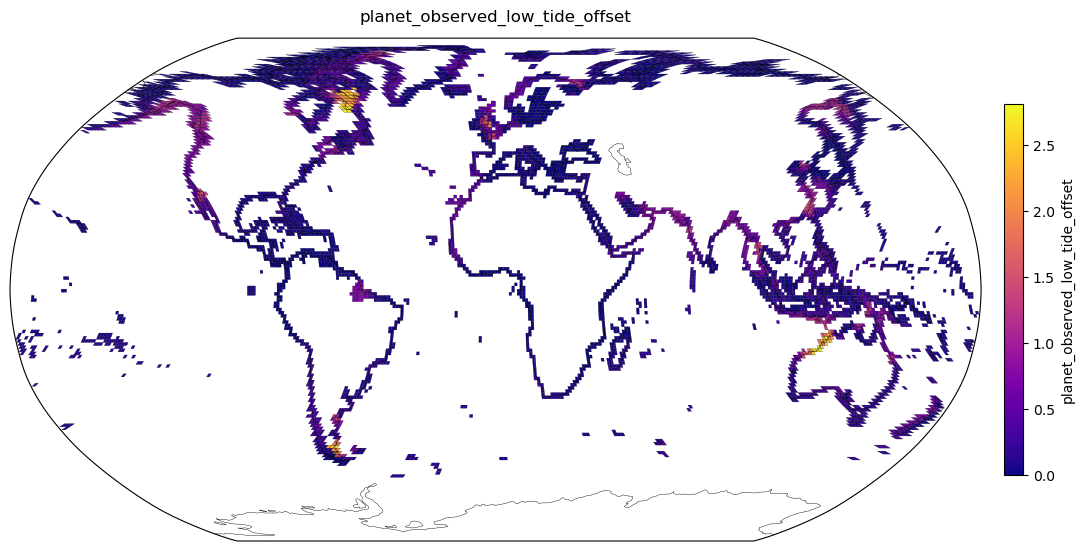

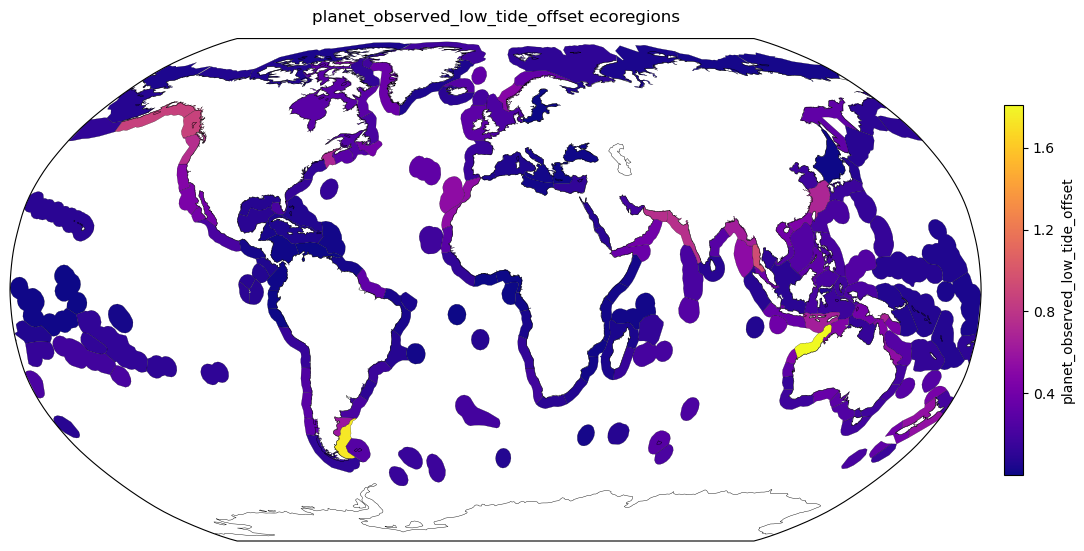

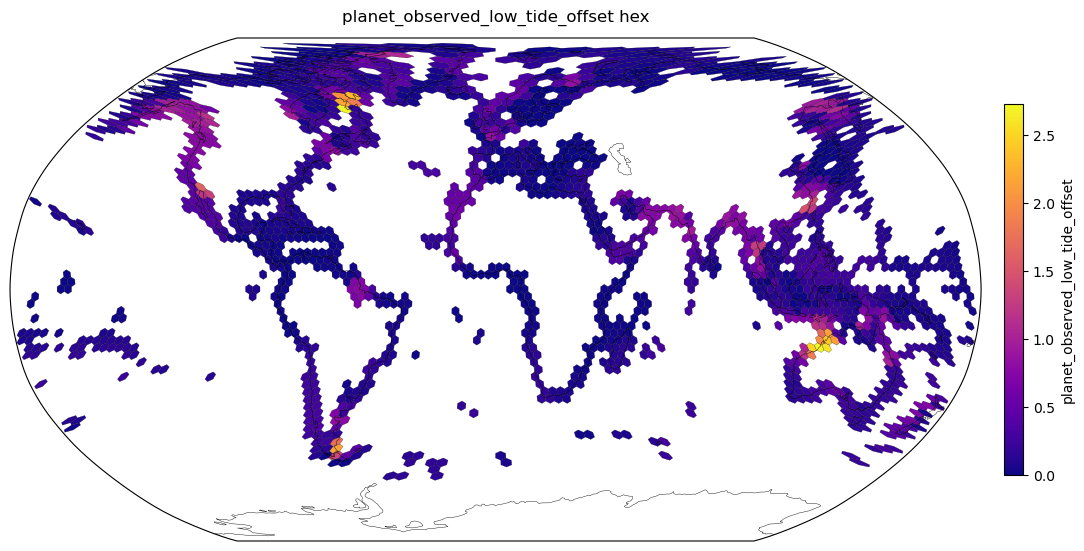

In [27]:
key = 'planet_observed_low_tide_offset'

plot_gdf_column(
    tide_heuristics_grid_df, 
    key, 
    title=key,
)

df = pd.DataFrame(tide_heuristics_grid_df.groupby("eco_id")[key].median())
df = df[df.index >= 0]
df = df.join(ecoregions[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(
    gdf, 
    key, 
    title=key + " ecoregions",
    # save_path="/Users/kyledorman/Desktop/tide_range_ecoregions.png"
)

df = pd.DataFrame(tide_heuristics_grid_df.groupby("hex_id")[key].median())
df = df[df.index >= 0]
df = df.join(hex_grid[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(
    gdf, 
    key, 
    title=key + " hex",
    # save_path="/Users/kyledorman/Desktop/tide_range_hex.png"
)

In [ ]:
df = pd.DataFrame(tide_heuristics_grid_df.groupby("2degree_id").tide_range.count())
df = df[df.index >= 0]
df = df.join(poly_grid_2[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(gdf, "tide_range", title="Tide Range")

plt.savefig("../tide_range_2_degree_grid_cell.png")

In [ ]:
plot_column(tide_heuristics_plot_df, 'planet_observed_low_tide_offset', "Planet Low Tide Offset")

In [ ]:
key = "planet_observed_low_tide_offset"

df = pd.DataFrame(tide_heuristics_plot_df.groupby("eco_id")[key].median())
df = df.rename(columns={key: "observed_low_tide_offset_median"})
df = df[df.index >= 0]
df = df.join(ecoregions[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_column(gdf, "observed_low_tide_offset_median", "Low Tide Offset")

In [ ]:
# ───────────────────────────────────────────────────────────────
# 2. axes layout: rows = sensors, cols = metrics
# ───────────────────────────────────────────────────────────────
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["count"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high")]

nrows, ncols  = len(sensors), len(metrics)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 4, nrows * 2),
    constrained_layout=True,
)

# ───────────────────────────────────────────────────────────────
# 3.  loop over columns (metrics) to set a shared scale per column
# ───────────────────────────────────────────────────────────────
cmap = "viridis"

for c, metric in enumerate(metrics):
    # shared vmin/vmax across sensors for this metric
    col_values = [f"{sat}_{metric}" for sat in sensors]
    vmin = tide_heuristics_pts_df[col_values].min().min()
    vmax = tide_heuristics_pts_df[col_values].max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for r, sensor in enumerate(sensors):
        ax      = axes[r, c]
        colname = f"{sensor}_{metric}"

        tide_heuristics_pts_df.plot(
            column     = colname,
            ax         = ax,
            cmap       = cmap,
            norm       = norm,
            marker     = "o",
            markersize = 1,
            linewidth  = 0,
            legend     = False,
        )

        # titles: top row gets metric title; first column gets sensor label
        ax.set_title(f"{sensor.title()} {metric.replace('_', ' ').title()}")
        ax.axis("off")

# add ONE colour‑bar for the whole column
sm = ScalarMappable(norm=norm, cmap=cmap);  sm.set_array([])
cax = fig.colorbar(sm, ax=axes[:, -1], shrink=0.6, pad=0.02, location="right")
cax.ax.set_ylabel(base_metrics[0].replace('_', ' ').title())

plt.savefig(FIG_DIR / "tide_count.png", dpi=300)
plt.show()

In [ ]:
# ───────────────────────────────────────────────────────────────
# 2. axes layout: rows = sensors, cols = metrics
# ───────────────────────────────────────────────────────────────
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["count"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high")]

nrows, ncols  = len(sensors), len(metrics)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 4, nrows * 2),
    constrained_layout=True,
)

# ───────────────────────────────────────────────────────────────
# 3.  loop over columns (metrics) to set a shared scale per column
# ───────────────────────────────────────────────────────────────
cmap = "viridis"

for c, metric in enumerate(metrics):
    # shared vmin/vmax across sensors for this metric
    col_values = [f"{sat}_{metric}" for sat in sensors]
    vmin = tide_heuristics_pts_df[col_values].min().min()
    vmax = 1
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for r, sensor in enumerate(sensors):
        ax      = axes[r, c]
        colname = f"{sensor}_{metric}"
        assert not tide_heuristics_pts_df[colname].isna().any()

        tide_heuristics_pts_df.plot(
            column     = colname,
            ax         = ax,
            cmap       = cmap,
            norm       = norm,
            marker     = "o",
            markersize = 1,
            linewidth  = 0,
            legend     = False,
        )

        # titles: top row gets metric title; first column gets sensor label
        ax.set_title(f"{sensor.title()} {metric.replace('_', ' ').title()}")
        ax.axis("off")

# add ONE colour‑bar for the whole column
sm = ScalarMappable(norm=norm, cmap=cmap);  sm.set_array([])
cax = fig.colorbar(sm, ax=axes[:, -1], shrink=0.6, pad=0.02, location="right")
cax.ax.set_ylabel(base_metrics[0].replace('_', ' ').title())

plt.savefig(FIG_DIR / "tide_count_binary.png", dpi=300)
plt.show()

In [ ]:
df = tide_heuristics_pts_df[tide_heuristics_pts_df.tide_range > 2.0]

# ───────────────────────────────────────────────────────────────
# 2. axes layout: rows = sensors, cols = metrics
# ───────────────────────────────────────────────────────────────
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["count"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high")]

nrows, ncols  = len(sensors), len(metrics)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 4, nrows * 2),
    constrained_layout=True,
)

# ───────────────────────────────────────────────────────────────
# 3.  loop over columns (metrics) to set a shared scale per column
# ───────────────────────────────────────────────────────────────
cmap = "viridis"

for c, metric in enumerate(metrics):
    # shared vmin/vmax across sensors for this metric
    col_values = [f"{sat}_{metric}" for sat in sensors]
    vmin = df[col_values].min().min()
    vmax = 1
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for r, sensor in enumerate(sensors):
        ax      = axes[r, c]
        colname = f"{sensor}_{metric}"
        assert not df[colname].isna().any()

        df.plot(
            column     = colname,
            ax         = ax,
            cmap       = cmap,
            norm       = norm,
            marker     = "o",
            markersize = 1,
            linewidth  = 0,
            legend     = False,
        )

        # titles: top row gets metric title; first column gets sensor label
        low_high = metric.split("_")[0]
        ax.set_title(f"{sensor.title()} {low_high.title()} Binary - Large Tidal Range")
        ax.axis("off")

# add ONE colour‑bar for the whole column
sm = ScalarMappable(norm=norm, cmap=cmap);  sm.set_array([])
cax = fig.colorbar(sm, ax=axes[:, -1], shrink=0.6, pad=0.05, location="right")
cax.ax.set_ylabel(base_metrics[0].replace('_', ' ').title())

plt.savefig(FIG_DIR / "tide_count_binary_large_range.png", dpi=300)
plt.show()

In [ ]:
# ───────────────────────────────────────────────────────────────
# 2. axes layout: rows = sensors, cols = metrics
# ───────────────────────────────────────────────────────────────
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["days_between_p95"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high", "mid")]

nrows, ncols  = len(sensors), len(metrics)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 4, nrows * 2),
    constrained_layout=True,
)

# ───────────────────────────────────────────────────────────────
# 3.  loop over columns (metrics) to set a shared scale per column
# ───────────────────────────────────────────────────────────────
cmap = "viridis"

for c, metric in enumerate(metrics):
    # shared vmin/vmax across sensors for this metric
    col_values = [f"{sat}_{metric}" for sat in sensors]
    vmin = 0 # tide_heuristics_pts_df[col_values].min().min()
    vmax = tide_heuristics_pts_df[col_values].max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for r, sensor in enumerate(sensors):
        ax      = axes[r, c]
        colname = f"{sensor}_{metric}"
        assert not tide_heuristics_pts_df[colname].isna().any(), colname

        tide_heuristics_pts_df.plot(
            column     = colname,
            ax         = ax,
            cmap       = cmap,
            norm       = norm,
            marker     = "o",
            markersize = 1,
            linewidth  = 0,
            legend     = False,
        )

        # titles: top row gets metric title; first column gets sensor label
        low_high = metric.split("_")[0]
        ax.set_title(f"{sensor.title()} {low_high.title()} Days Between p95")
        ax.axis("off")

# add ONE colour‑bar for the whole column
sm = ScalarMappable(norm=norm, cmap=cmap);  sm.set_array([])
cax = fig.colorbar(sm, ax=axes[:, -1], shrink=0.6, pad=0.02, location="right")
cax.ax.set_ylabel(base_metrics[0].replace('_', ' ').title())

plt.savefig(FIG_DIR / "tide_days_between_p95.png", dpi=300)
plt.show()

In [ ]:
df = tide_heuristics_pts_df[tide_heuristics_pts_df.tide_range > 2.0]

# ───────────────────────────────────────────────────────────────
# 2. axes layout: rows = sensors, cols = metrics
# ───────────────────────────────────────────────────────────────
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["days_between_p95"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high", "mid")]

nrows, ncols  = len(sensors), len(metrics)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 4, nrows * 2),
    constrained_layout=True,
)

# ───────────────────────────────────────────────────────────────
# 3.  loop over columns (metrics) to set a shared scale per column
# ───────────────────────────────────────────────────────────────
cmap = "viridis"

for c, metric in enumerate(metrics):
    # shared vmin/vmax across sensors for this metric
    col_values = [f"{sat}_{metric}" for sat in sensors]
    vmin = 0 # df[col_values].min().min()
    vmax = df[col_values].max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for r, sensor in enumerate(sensors):
        ax      = axes[r, c]
        colname = f"{sensor}_{metric}"
        assert not df[colname].isna().any(), colname

        df.plot(
            column     = colname,
            ax         = ax,
            cmap       = cmap,
            norm       = norm,
            marker     = "o",
            markersize = 1,
            linewidth  = 0,
            legend     = False,
        )

        # titles: top row gets metric title; first column gets sensor label
        ax.set_title(f"{sensor.title()} {metric.replace('_', ' ').title()}" + } - Large Tidal Range)
        ax.axis("off")

# add ONE colour‑bar for the whole column
sm = ScalarMappable(norm=norm, cmap=cmap);  sm.set_array([])
cax = fig.colorbar(sm, ax=axes[:, -1], shrink=0.6, pad=0.02, location="right")
cax.ax.set_ylabel(base_metrics[0].replace('_', ' ').title())

plt.savefig(FIG_DIR / "tide_days_between_p95_large_range.png", dpi=300)
plt.show()

In [ ]:
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["count"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high", "mid")]

for metric in metrics:
    print(metric, "% No observations")
    for sensor in sensors:
        print(sensor, round(100 * (tide_df[f'{sensor}_{metric}'] == 0).sum() / len(tide_df), 1))

In [ ]:
df = tide_heuristics_grid_df[tide_heuristics_grid_df.tide_range > 2.0]
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["count"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high", "mid")]

for metric in metrics:
    print(metric, "% No observations - Large Range")
    for sensor in sensors:
        print(sensor, round(100 * (df[f'{sensor}_{metric}'] == 0).sum() / len(tide_df), 1))

In [ ]:
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["days_between_p95"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high", "mid")]

for metric in metrics:
    print(metric, "% > 100 days")
    for sensor in sensors:
        print(sensor, round(100 * (tide_df[f'{sensor}_{metric}'] > 100).sum() / len(tide_df), 1))

In [ ]:
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["days_between_p95"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high", "mid")]

for metric in metrics:
    print(metric, "median")
    for sensor in sensors:
        print(sensor, round(tide_df[f'{sensor}_{metric}'].median(), 1))

In [ ]:
df = tide_heuristics_grid_df[tide_heuristics_grid_df.tide_range > 2.0]
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["days_between_p95"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high", "mid")]

for metric in metrics:
    print(metric, "median - Large Range")
    for sensor in sensors:
        print(sensor, round(df[f'{sensor}_{metric}'].median(), 1))

In [ ]:
sensors = ["planet", "sentinel", "landsat"]
levels = ["low", "high"]

for lvl in levels:
    metric = f"observed_{lvl}_tide_offset"
    print(metric, "median")
    for sensor in sensors:
        print(sensor, round(tide_df[f'{sensor}_{metric}'].median(), 1))
    print("")

In [ ]:
sensors = ["planet", "sentinel", "landsat"]

metric = f"observed_spread"
print(metric, "median")
for sensor in sensors:
    print(sensor, round(tide_df[f'{sensor}_{metric}'].median(), 1))

In [ ]:
sensors = ["planet", "sentinel", "landsat"]
levels = ["low", "high"]

for lvl in levels:
    metric = f"observed_{lvl}_tide_offset_rel"
    print(metric, "median")
    for sensor in sensors:
        print(sensor, round(tide_df[f'{sensor}_{metric}'].median(), 1))
    print("")

In [ ]:
tide_heuristics_grid_df.tide_range.hist()

In [ ]:
[c for c in tide_heuristics_plot_df.columns.tolist() if c.startswith("planet")]

In [ ]:
m.crs

In [ ]:
df = pd.DataFrame(tide_heuristics_plot_df.groupby("eco_id").planet_high_days_between_p95.median())
# df = df.rename(columns={"planet_high_days_between_p95": "tide_range_median"})
df = df[df.index >= 0]
df = df.join(ecoregions[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=tide_heuristics_plot_df.crs)

# Choose an equal-area polar stereographic (EPSG:3413 = Arctic)
gdf_proj = gdf.to_crs("ESRI:54030")

fig, ax = plt.subplots(figsize=(8, 8))
gdf_proj.plot(ax=ax, linewidth=0.4, edgecolor="k", facecolor="#4c78a8")
ax.set_title("Robinson (ESRI:54030)")
ax.set_axis_off()
plt.tight_layout()

In [ ]:
df = pd.DataFrame(tide_heuristics_plot_df.groupby("eco_id").planet_high_days_between_p95.median())
# df = df.rename(columns={"planet_high_days_between_p95": "tide_range_median"})
df = df[df.index >= 0]
df = df.join(ecoregions[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=tide_heuristics_plot_df.crs)

# Choose an equal-area polar stereographic (EPSG:3413 = Arctic)
gdf_proj = gdf.to_crs("ESRI:54009")

fig, ax = plt.subplots(figsize=(8, 8))
gdf_proj.plot(ax=ax, linewidth=0.4, edgecolor="k", facecolor="#4c78a8")
ax.set_title("Mollweide - ESRI:54009")
ax.set_axis_off()
plt.tight_layout()

In [ ]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt

# Mollweide - ESRI:54009
# Robinson - ESRI:54030

# Pick any Cartopy projection
proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

fig = plt.figure(figsize=(8, 8))
ax  = plt.axes(projection=proj)

# Re-project your data on the fly with `transform`
gdf.to_crs("ESRI:54030").plot(ax=ax, facecolor="royalblue", edgecolor="white", linewidth=0.2)

ax.coastlines(linewidth=0.3)
ax.gridlines(draw_labels=True, linewidth=0.2)
ax.set_title("Interactive Cartopy map in Robinson", pad=12)
plt.show()

In [ ]:
ca_ocean.crs

In [ ]:
import plotly.express as px
import geopandas as gpd

# Convert GeoDataFrame → GeoJSON FeatureCollection
gdf_wgs84 = gdf.reset_index().to_crs("EPSG:4326")          # Plotly expects lon/lat
geojson = gdf_wgs84.__geo_interface__

fig = px.choropleth(
    gdf_wgs84,
    geojson=geojson,
    locations="eco_id",             # match on this column
    featureidkey="properties.eco_id",   # where it lives in each feature
    color="planet_high_days_between_p95",
    color_continuous_scale="Viridis",
    # mapbox_style="carto-positron",
    projection="robinson",               # <- anything in Plotly docs
    center={"lat": 80, "lon": 0},
)
fig.update_geos(
    projection_type="robinson",
    showland=True,  landcolor="#ececec",
    showocean=True, oceancolor="#c6dbef",
    showcountries=True, countrycolor="#999",
    showcoastlines=True, coastlinecolor="#666",
    fitbounds="locations", 
    visible=False
)
fig.update_layout(margin=dict(l=0, r=0, t=40, b=0))
fig.show()

In [ ]:
print(fig.data[0].featureidkey)   # should show whatever you set, e.g. 'id'
print(fig.data[0].locations[:5])  # first few ids Plotly will look for

In [ ]:
# 1. Inspect a single feature
feat0 = geojson["features"][0]
print("Feature id:", feat0.get("id"))
print("Properties keys:", feat0["properties"].keys())

# 2. Make sure one id matches
assert str(gdf_wgs84.loc[gdf_wgs84.index[0], "map_id"]) in (
    feat0.get("id"), feat0["properties"].get("map_id")
)

In [ ]:
import json
import urllib.request



# Load US county GeoJSON data
with urllib.request.urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response:
   counties = json.load(response)

# Sample data
df = pd.DataFrame({
   'fips': ['01001', '01003', '01005'],
   'unemp': [5, 7, 6]
})

fig = px.choropleth(df,
                   geojson=counties,
                   locations='fips',
                   color='unemp',
                   color_continuous_scale="Viridis",
                   scope="usa",
                   labels={'unemp': 'unemployment rate'})
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [ ]:
df = pd.DataFrame(tide_heuristics_plot_df.groupby("eco_id").planet_high_days_between_p95.median())
# df = df.rename(columns={"planet_high_days_between_p95": "tide_range_median"})
df = df[df.index >= 0]
df["log_p95"] = np.log10(df.planet_high_days_between_p95) - 1
df = df.join(ecoregions[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=tide_heuristics_plot_df.crs).to_crs('EPSG:4326')

key = 'log_p95'

# --- Folium map for % ---
if gdf[key].max() == gdf[key].min():
    scale_min = 0
else:
    scale_min = gdf[key].min()
color_scale = linear.viridis.scale(scale_min, gdf[key].max())

m = folium.Map(
    location=[plot_center.y, plot_center.x], 
    zoom_start=2, 
    tiles=None,
    # attr="NASA GIBS BlueMarble",
    width=1100,
    height=500,
    crs='EPSG4326',

)

for gid, row in gdf.iterrows():
    value = row[key]
    geom = row.geometry
    folium.GeoJson(
        data=geom,
        style_function=lambda f, col=color_scale(value): {
            "fillColor": col,
            "color":     col,      # outline same as fill
            "weight":    1,
            "fillOpacity": 0.7,
        },
        tooltip=f"{gid}: {value:0.1f}",
    ).add_to(m)

color_scale.caption = 'log10(planet_high_days_between_p95)'
color_scale.add_to(m)

m

In [ ]:
key = "eco_id"
base_df = ecoregions

# a) Re-project to lon/lat
gdf = base_df[[key, "geometry"]].copy()

# b) Guarantee the key is **string** everywhere
gdf[key] = gdf[key].astype(str)

# c) Dump GeoJSON so 'plot_id' lives in properties
geojson = json.loads(gdf.to_json())      # <- safer than __geo_interface__

fig = px.choropleth(
    gdf,
    geojson=geojson,
    locations=key,                 # column in the DF
    featureidkey=f"properties.{key}",   # same name in every feature
    color=key,                                  # colour by ID
    color_discrete_sequence=px.colors.qualitative.Set2,
    projection="robinson",
)

fig.update_geos(
    projection_type="robinson",
    showland=True,  landcolor="#ececec",
    showocean=True, oceancolor="#c6dbef",
    showcountries=True, countrycolor="#999",
    showcoastlines=True, coastlinecolor="#666",
    fitbounds="locations", 
    visible=False
)

fig.update_layout(margin=dict(l=0, r=0, t=40, b=0))
fig.show()